# Experiment 4

In [2]:

import pandas as pd
import numpy as np

import quantstats as qs
from tinycta.port import build_portfolio
from tinycta.signal import *


In [4]:
# Load prices
prices = pd.read_csv("data/Prices_hashed.csv", index_col=0, parse_dates=True).ffill()

In [9]:
from ipywidgets import Label, HBox, VBox, IntSlider, FloatSlider

fast = IntSlider(min=4, max=192, step=4, value=32)
slow = IntSlider(min=4, max=192, step=4, value=96)
vola = IntSlider(min=4, max=192, step=4, value=32)
winsor = FloatSlider(min=1.0, max=6.0, step=0.1, value=4.2)
left_box = VBox([Label("Fast Moving Average"), Label("Slow Moving Average"), Label("Volatility"), Label("Winsorizing")])
right_box = VBox([fast, slow, vola, winsor])
HBox([left_box, right_box])

In [10]:
mu = np.tanh(prices.apply(returns_adjust, com=vola.value, clip=winsor.value).cumsum().apply(osc, fast=fast.value, slow=slow.value))
volax = prices.pct_change().ewm(com=vola.value, min_periods=vola.value).std()

# compute the series of Euclidean norms by compute the sum of squares for each row
euclid_norm = np.sqrt((mu*mu).sum(axis=1))

# Divide each column of mu by the Euclidean norm
risk_scaled = mu.apply(lambda x: x/euclid_norm, axis=0)

portfolio = build_portfolio(prices=prices, cashposition=1e6*risk_scaled/volax)

/Users/a13069q/github/cs/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

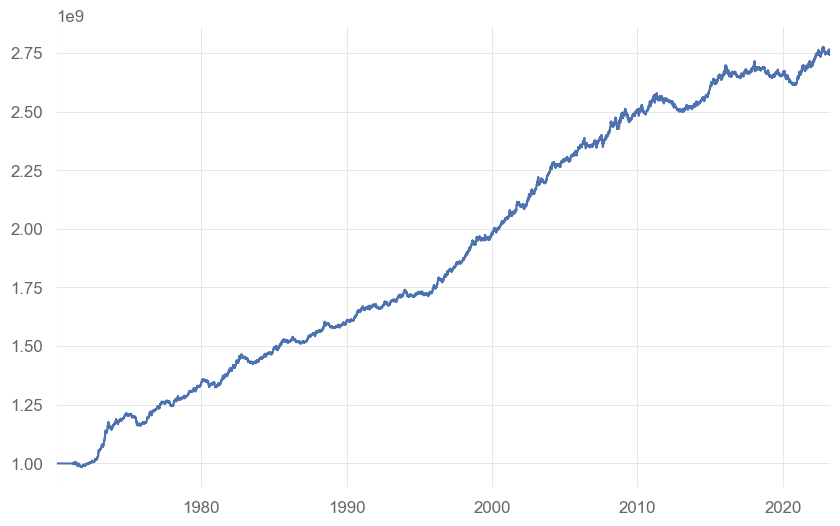

In [12]:
capital = 1e9
a = portfolio.nav(aum=capital)
a.plot()

                    Strategy
------------------  ----------
Start Period        1970-01-02
End Period          2023-04-26
Risk-Free Rate      0.0%
Time in Market      97.0%

Cumulative Return   176.01%
CAGR﹪              1.32%

Sharpe              1.15
Prob. Sharpe Ratio  100.0%
Sortino             1.69
Sortino/√2          1.19
Omega               1.22

Max Drawdown        -4.49%
Longest DD Days     1471

Gain/Pain Ratio     0.22
Gain/Pain (1M)      1.35

Payoff Ratio        1.01
Profit Factor       1.22
Common Sense Ratio  1.3
CPC Index           0.67
Tail Ratio          1.07
Outlier Win Ratio   3.62
Outlier Loss Ratio  3.46

MTD                 0.27%
3M                  0.48%
6M                  -0.31%
YTD                 0.23%
1Y                  0.69%
3Y (ann.)           1.04%
5Y (ann.)           0.4%
10Y (ann.)          0.65%
All-time (ann.)     1.32%

Avg. Drawdown       -0.32%
Avg. Drawdown Days  33
Recovery Factor     22.79
Ulcer Index         0.01
Serenity Index      4.07


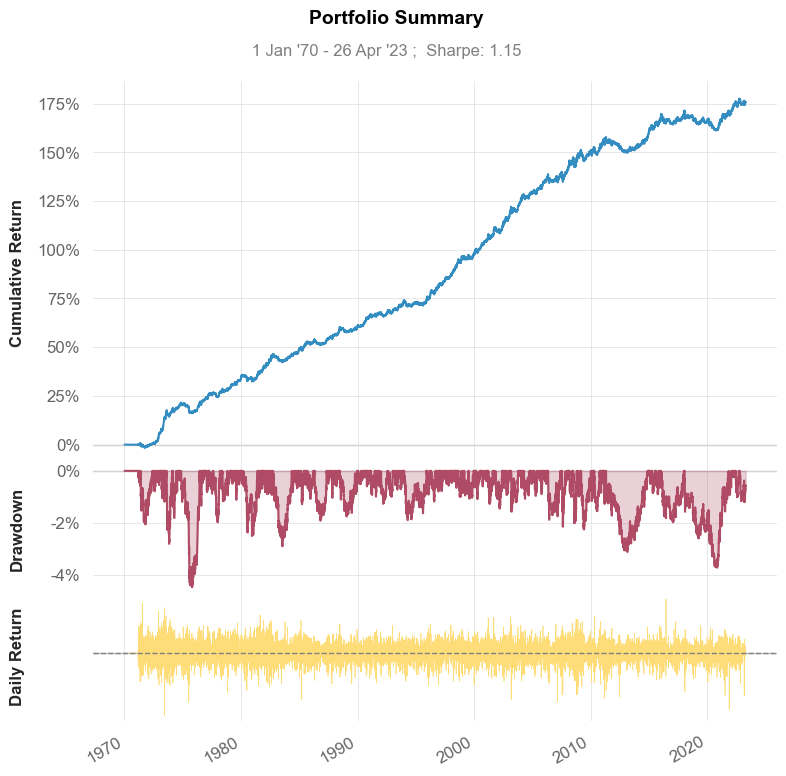

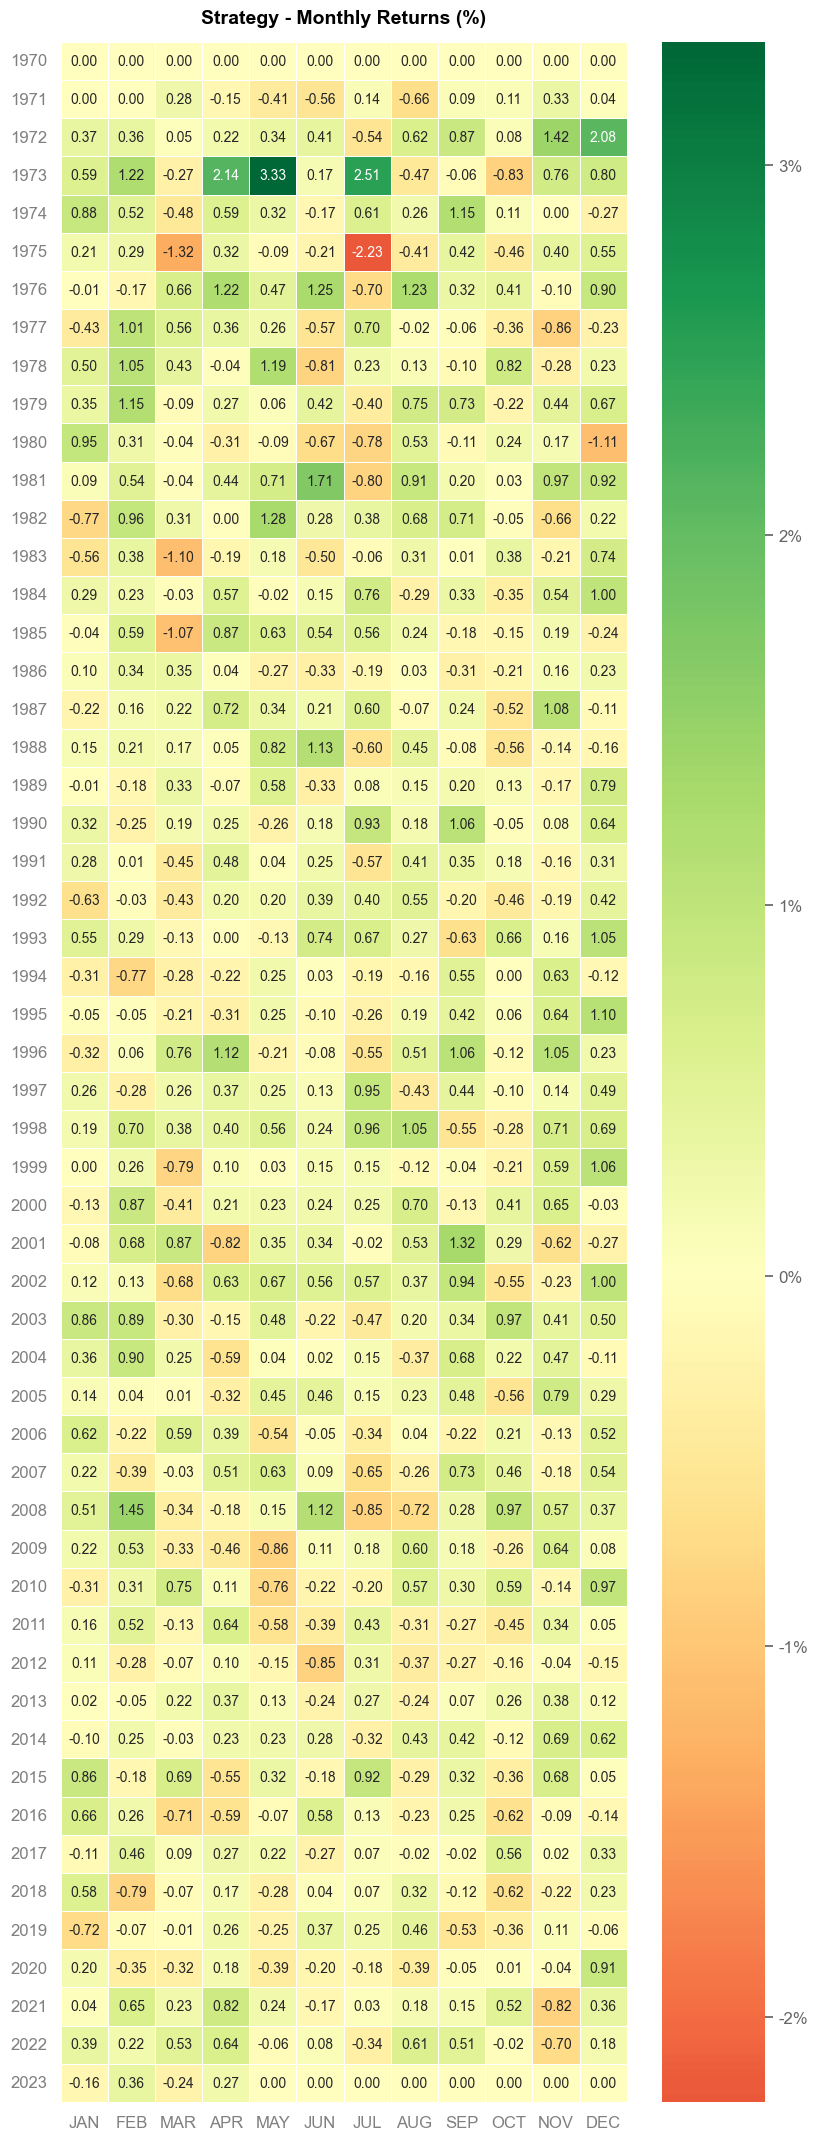

In [13]:
qs.reports.basic(a)